In [1]:
# Imports and general configurations

import matplotlib.pyplot as plt
import nets as n
import functions as f
import torch.optim as optim
import torch.nn as nn
import torch as tc
import numpy as np

from torch.utils.data import DataLoader

get_ipython().magic(u'load_ext autoreload')  # pylint: disable=undefined-variable
get_ipython().magic(u'autoreload 2')         # pylint: disable=undefined-variable


sample_type = f.SampleType.TRIANGLE  # LINE, SQUARE, TRIANGLE, SAW, DIAMOND
mu = [[0, 0]]
sigma = np.eye(2)*0

interval_min = 10
interval_max = 100
slope = 5
bias = 0

n_samples = 1000*32
seed = 0

dropout_p = 0.2
last_layer_bias = True
use_cuda = True
normalize_dist = False
unique_test = True


In [2]:
# Training samples generation

X = f.ShapeSample(sample_type, interval_min, interval_max, slope, bias, n_samples)

X[:, 1] = X[:, 1] + f.GMMsample(mu, sigma, n=n_samples)[:, 1]

if normalize_dist:
    max_X = np.amax(X, 0)
    min_X = np.amin(X, 0)
    print(max_X, min_X)
    X = np.true_divide(np.subtract(X, min_X), np.subtract(max_X, min_X))
    max_X = np.amax(X, 0)
    min_X = np.amin(X, 0)
    print(max_X, min_X)



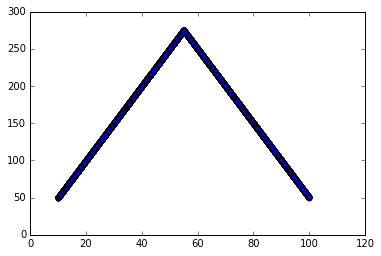

In [3]:
# Training samples plot

# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(X[:,0], X[:,1], X[:,2])
# plt.show()

plt.scatter(X[:, 0], X[:, 1])
plt.show()



In [4]:
# Dataset and NN initialization

dataset = n.MatrixDataset(X)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

net = n.FCNet(dropout_p=dropout_p, last_layer_bias=last_layer_bias)
n.to_cuda(net, use_cuda)

# Loss function and optimizer
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
# criterion = n.LogLikelihoodLoss(use_cuda=use_cuda)
# criterion = nn.BCELoss()
# criterion = nn.KLDivLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)



CUDA not available


In [5]:
# Training

net.train()

n_epochs = 1000
running_loss = 0.0

verbose = True
print_loss_every = 500

for epoch in range(n_epochs):
    if verbose:
        print('> EPOCH %d/%d' % (epoch + 1, n_epochs))
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()

        x = n.to_variable(data['x'].float(), use_cuda)
        y = n.to_variable(data['y'].float(), use_cuda)
        y_ = net(x)

        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()

        if verbose:
            running_loss += loss.data[0]
            if (i + 1) % print_loss_every == 0:  # print every 'print_loss_every' mini-batches
                print('[%5d] loss: %.3f' %
                      (i + 1, running_loss / print_loss_every))
                running_loss = 0.0



EPOCH 662/1000
[  500] loss: 54.382
[ 1000] loss: 53.493
> EPOCH 663/1000
[  500] loss: 56.678
[ 1000] loss: 58.688
> EPOCH 664/1000
[  500] loss: 55.245
[ 1000] loss: 55.249
> EPOCH 665/1000
[  500] loss: 55.895
[ 1000] loss: 55.243
> EPOCH 666/1000
[  500] loss: 56.215
[ 1000] loss: 56.427
> EPOCH 667/1000
[  500] loss: 55.918
[ 1000] loss: 56.476
> EPOCH 668/1000
[  500] loss: 55.920
[ 1000] loss: 53.720
> EPOCH 669/1000
[  500] loss: 56.011
[ 1000] loss: 53.885
> EPOCH 670/1000
[  500] loss: 57.859
[ 1000] loss: 55.375
> EPOCH 671/1000
[  500] loss: 54.108
[ 1000] loss: 56.532
> EPOCH 672/1000
[  500] loss: 55.355
[ 1000] loss: 55.744
> EPOCH 673/1000
[  500] loss: 55.956
[ 1000] loss: 54.118
> EPOCH 674/1000
[  500] loss: 54.686
[ 1000] loss: 55.122
> EPOCH 675/1000
[  500] loss: 53.920
[ 1000] loss: 55.396
> EPOCH 676/1000
[  500] loss: 56.820
[ 1000] loss: 53.961
> EPOCH 677/1000
[  500] loss: 56.298
[ 1000] loss: 56.747
> EPOCH 678/1000
[  500] loss: 54.555
[ 1000] loss: 53.851

In [6]:
# Validation

net.eval()

n_dropout_samples = 300
interval_min_ = interval_min
interval_max_ = interval_max

if unique_test:  # TO-DO: make it able to deal with multidimensional input
    if normalize_dist:
        X_ = np.arange(0, 1, .01)
    else:
        X_ = X[:, :-1]
        X_ = np.arange(interval_min_, interval_max_,
                       (interval_max_ - interval_min_)/200.0)
    X_ = np.expand_dims(X_, axis=1)
else:
    X_ = X[:, :-1]

Y = np.zeros([X_.shape[0]*n_dropout_samples, X_.shape[1]+1])

for i in range(len(X_)):
    x = X_[i, :]
    x_ = n.to_variable(tc.FloatTensor(x), use_cuda)
    for j in range(n_dropout_samples):
        y = net(x_).data.cpu().numpy()
        Y[i*n_dropout_samples+j, :] = np.concatenate((x, y), axis=0)

# print Y



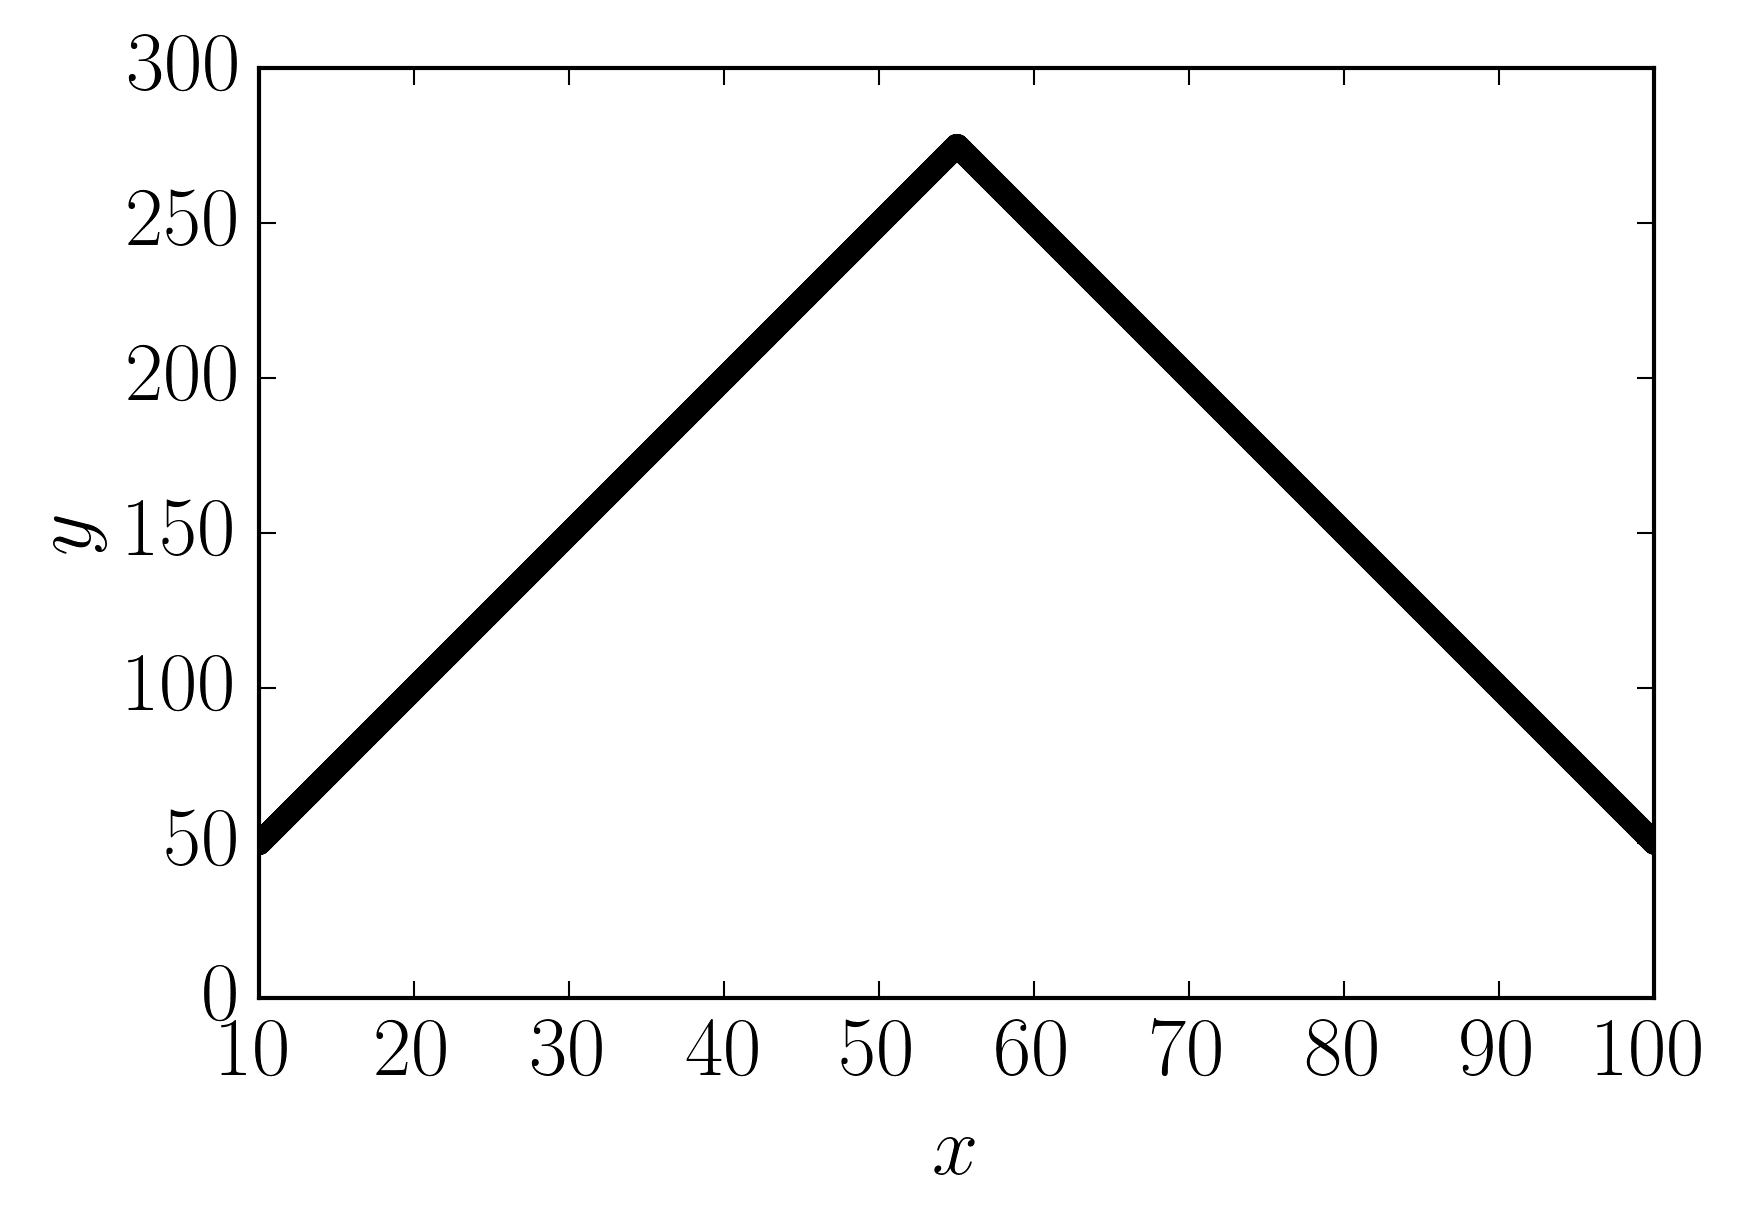

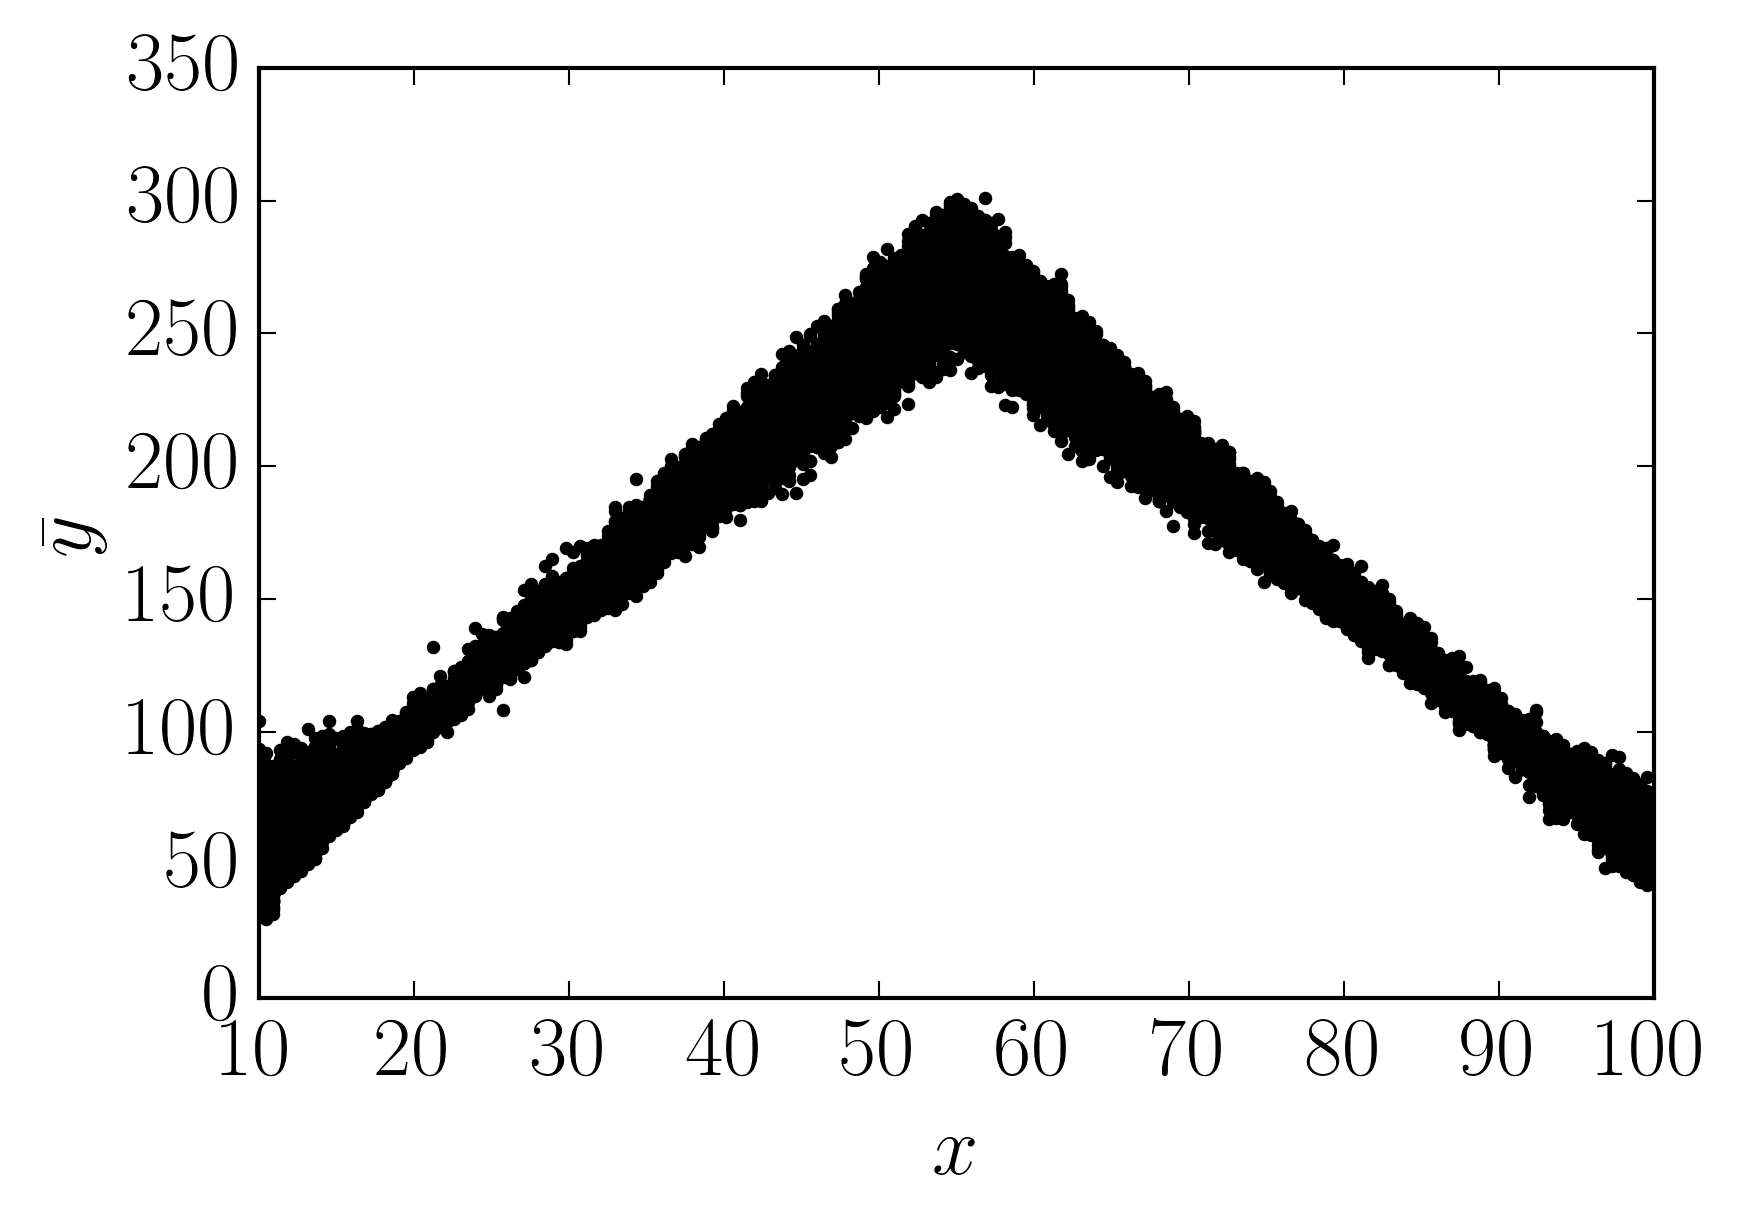

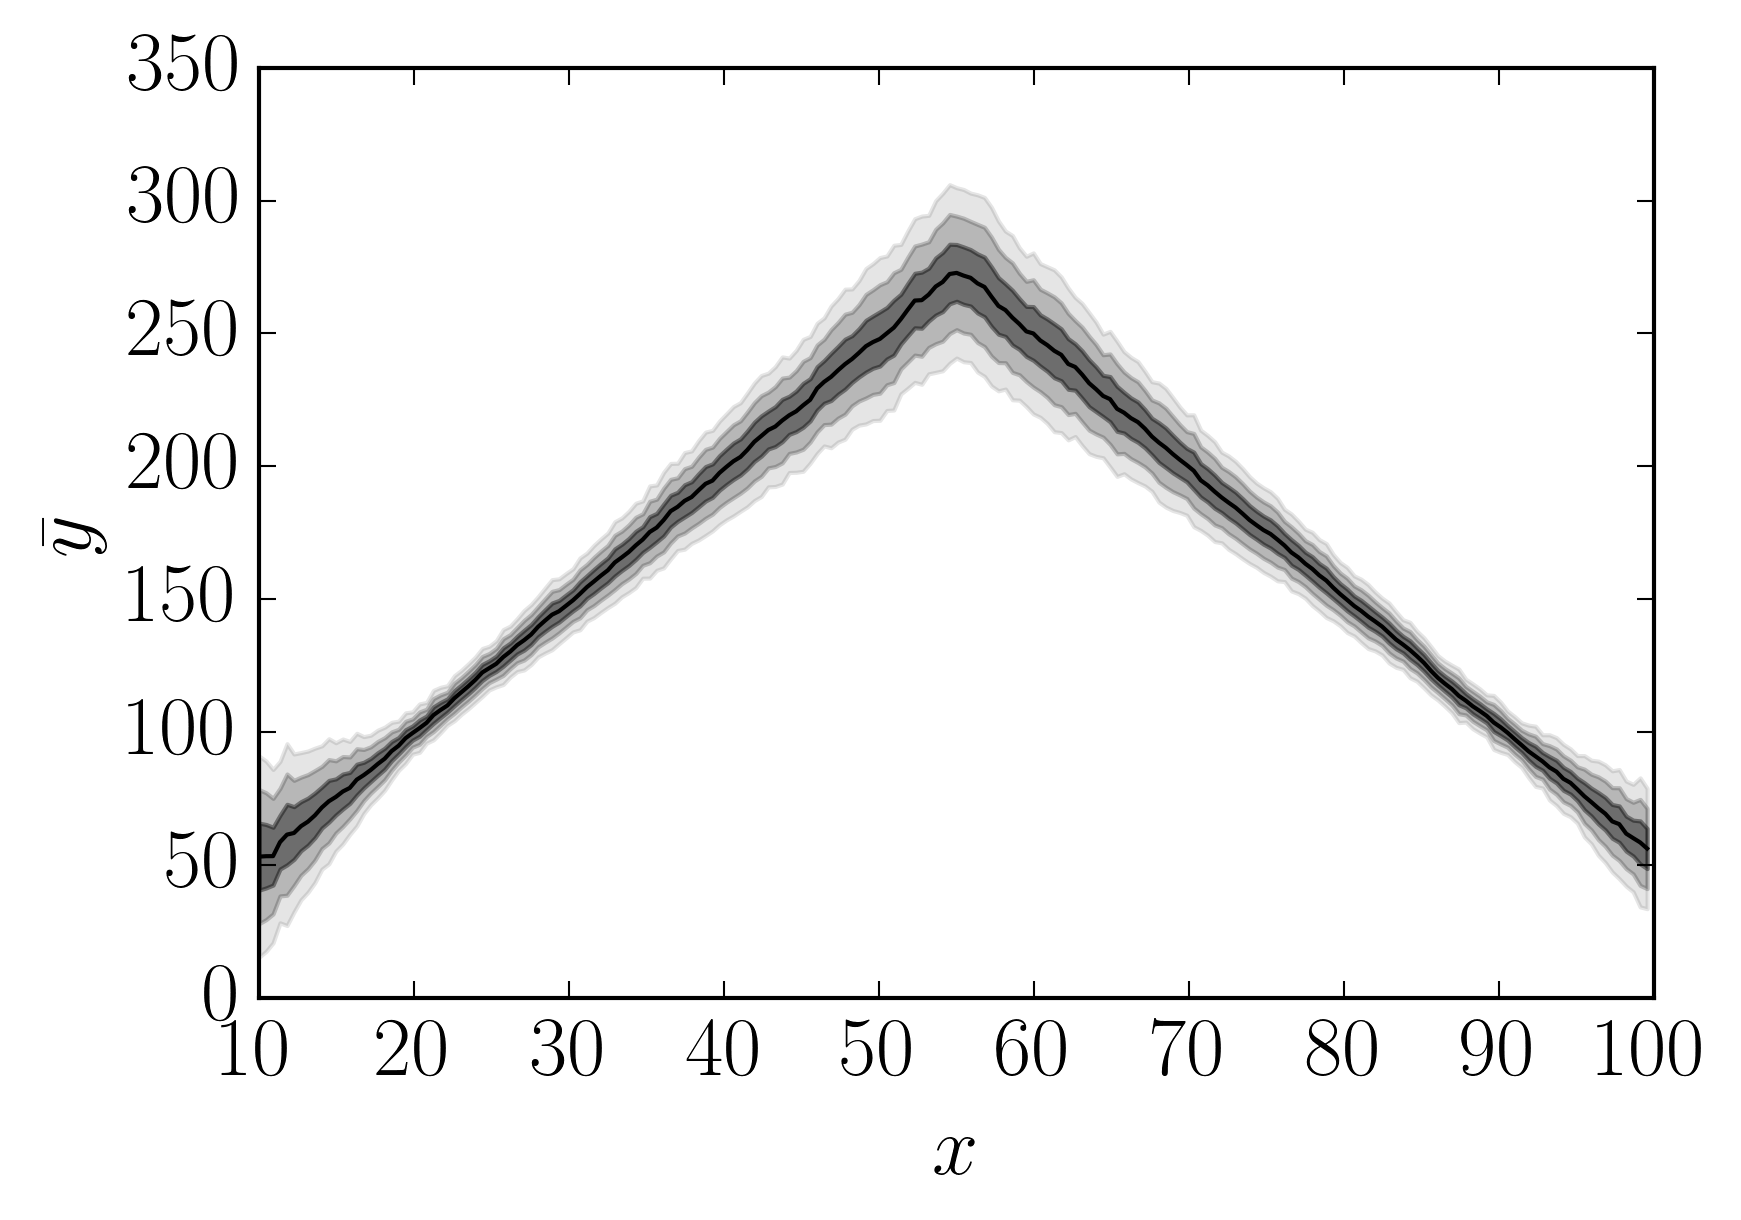

In [7]:
# Validiation plots

Y_ = Y[:, 1].reshape(-1, n_dropout_samples)
Y_mean = np.mean(Y_, axis=1)
Y_std = np.std(Y_, axis=1)
Y_2std = Y_std * 2
Y_3std = Y_std * 3

if sample_type == f.SampleType.LINE:
    Y_true = slope * X_ + bias
elif sample_type == f.SampleType.SQUARE:
    Y_true = slope * np.power(X_, 2) + bias
elif sample_type == f.SampleType.TRIANGLE:
    interval_half = (interval_max_ - interval_min_)/2.0 + interval_min_
    Y_true = (X_ < interval_half) * (slope * X_ + bias) + \
        (X_ >= interval_half) * (slope * (interval_min_ + interval_max_ - X_) + bias)
else:  # sample_type == f.SampleType.SAW
    interval_half = (interval_max_ - interval_min_)/2.0 + interval_min_
    Y_true = (X_ < interval_half) * (slope * X_ + bias) + \
        (X_ >= interval_half) * (slope * (X_ - interval_half - interval_min_) + bias)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20})

exp_name = sample_type.name.lower() + "_" + (str(dropout_p) if 'dropout_p' in locals() else "0.5") + "_" + ("bias" if last_layer_bias else "nobias")

fig = plt.figure(dpi=300)
# ax = Axes3D(fig)
# ax.scatter(X[:,0], X[:,1], X[:,2])
# plt.show()

plt.scatter(X[:, 0], X[:, 1], color='black', rasterized=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(interval_min_, interval_max_)
plt.show()

fig.savefig("plots/" + exp_name + "_1.pdf", bbox_inches='tight')

fig = plt.figure(dpi=300)
# ax = Axes3D(fig)
# ax.scatter(Y[:,0], Y[:,1], Y[:,2])
# plt.show()

plt.scatter(Y[:, 0], Y[:, 1], marker='.', color='black', rasterized=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$\bar{y}$')
#plt.plot(X_, Y_true, 'r--')
plt.xlim(interval_min_, interval_max_)
plt.show()

fig.savefig("plots/" + exp_name + "_2.pdf", bbox_inches='tight')

fig = plt.figure(dpi=300)

plt.plot(X_, Y_mean, 'k-', color='black', rasterized=True)
#plt.plot(X_, Y_true, 'r--')
plt.fill_between(X_.squeeze(), Y_mean - Y_std, Y_mean + Y_std, color='black', alpha=0.4)
plt.fill_between(X_.squeeze(), Y_mean - Y_2std, Y_mean + Y_2std, color='black', alpha=0.2)
plt.fill_between(X_.squeeze(), Y_mean - Y_3std, Y_mean + Y_3std, color='black', alpha=0.1)
plt.xlabel(r'$x$')
plt.ylabel(r'$\bar{y}$')
plt.xlim(interval_min_, interval_max_)
plt.show()

fig.savefig("plots/" + exp_name + "_3.pdf", bbox_inches='tight')